In [27]:
import os,sys
import pandas as pd
import warnings
from matplotlib import pyplot as plt
warnings.filterwarnings('ignore')

os.chdir('C:/kongjy_special/实习工作内容总结/201805-201808华泰证券/Task4/')
sys.path.append('C:\\kongjy_special\\实习工作内容总结\\201805-201808华泰证券\\Task4')
import Tools_kjy

#['/20180502', '/20180503', '/20180504', '/20180507', '/20180508', '/20180509',
# '/20180510', '/20180511', '/20180514', '/20180515', '/20180516', '/20180517',
# '/20180518', '/20180521']
date = "20180504"

tempTick = pd.read_csv('Java_log_orders_600519/Tick'+date+'.csv')
tempTick = tempTick.reset_index().rename(columns={"index":"Timestamp"})
tempTick['Timestamp'] = pd.to_datetime(tempTick['Timestamp'])
tempTick['median_5'] = (tempTick['AskP0'].rolling(window=5,min_periods=1).median()).shift(-2).fillna(0)
tempTick['median_5'],_ = Tools_kjy.smooth(tempTick['median_5'])
tempTick['EMA_median'] = tempTick['median_5'].rolling(window=5,min_periods=1).mean().shift(-2)

tempTest = pd.read_csv('Java_log_orders_600519/600519.SH_back_test_info_'+date+'.csv')
tickindex = tempTest[tempTest.order != " "].index 

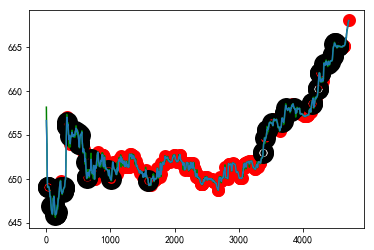

In [28]:
tempTick['diff1_EMAmedian'] = tempTick['EMA_median'].diff()
tempTick['former1'] = tempTick['diff1_EMAmedian'].rolling(window=2).apply\
                (lambda x:pd.np.cumprod(x)[-1]).shift(-1)
def threecom(x):
    if (x[0] == 0) and (x[1]==0) and (x[2]==0):
        return 0
    if (x[0]>=0) and (x[1]<= 0) and (x[2]>=0):
        return 1
    else:
        return 0
tempTick['is_transi'] = tempTick['former1'].rolling(window=3).apply(threecom).shift(-1)
    #考虑5Tick趋势不变 >0  去除小突刺
def Delete_5equal(x):
    if (x==1).sum() < 2:
        return 0
    else:
        return 1
tempTick['Delete_5equal'] = tempTick['is_transi'].rolling(window=5).apply(Delete_5equal)
for i in tempTick[tempTick.Delete_5equal == 1].index:
    if (tempTick.loc[i+1,'diff1_EMAmedian'] * tempTick.loc[i-3,'diff1_EMAmedian'] >0) and\
    (tempTick.loc[i-2:i,'diff1_EMAmedian'].cumprod().iloc[-1]==0):
        tempTick.loc[i-4:i,'is_transi'] = 0
    #相邻间隔趋势不变，解决长平
index_transi = tempTick[tempTick['is_transi'] == 1].index
for i in range(index_transi.shape[0]-1):
    thisi = index_transi[i]
    nexti = index_transi[i+1]
    if (sum(tempTick.loc[thisi+1:nexti,'diff1_EMAmedian']) == 0)\
    and (tempTick.loc[thisi,'diff1_EMAmedian'] * tempTick.loc[nexti+1,'diff1_EMAmedian']>0):
        tempTick.loc[thisi,'is_transi'] = 0
        tempTick.loc[nexti,'is_transi'] = 0
        
plt.figure(1)
index_transi = tempTick[tempTick['is_transi'] == 1].index
plt.scatter(index_transi,tempTick.loc[index_transi,'EMA_median'],c='r',linewidths=7,label='转变点')
plt.plot(tempTick.median_5[:-10],c='g',label='median_5')
plt.plot(tempTick.EMA_median[:-10],label='SMA_median_5')
plt.scatter(tickindex,tempTick.loc[tickindex,'EMA_median'],c='k',linewidths=15,label='下单点')
plt.show()

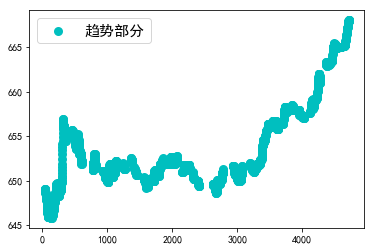

In [29]:
# 统计是否为趋势 30Tick周期以上的为趋势部分 其余为非趋势部分
# index_transi 是统计的每个趋势的划分点，我们要做的就是计算index_transi相邻间隔
TrendPeriod = 15
trendindex = pd.np.where(pd.Series(index_transi).diff() > TrendPeriod)[0]
trend = pd.Series([0] * tempTick.shape[0])
for i in trendindex:
    thisindex = index_transi[i]
    lastindex = index_transi[i-1]
    trend[lastindex:thisindex+1] = 1
trenddataindex = trend[trend == 1].index
plt.figure(1)
plt.scatter(trenddataindex,tempTick.loc[trenddataindex,'EMA_median'],c='c',linewidths=3,label='趋势部分')
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.legend(fontsize=15)
plt.show()

In [30]:
###############################################################################
#统计趋势的话，就是 tickindex在趋势内的部分有多少
trendtickindex = [i for i in tickindex if i in trenddataindex]
print ("趋势周期%s , 下单点下在趋势部分的概率为 %.3f "%(TrendPeriod,len(trendtickindex)/len(tickindex)))


趋势周期20 , 下单点下在趋势部分的概率为 0.605 
